# P-Median problem
[![p_median.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/location/p_median.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/location/p_median.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/location/p_median.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/location/p_median.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/location/p_median.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/location/p_median.ipynb)](https://colab.ampl.com)

Description: this notebook states the p-median problem with a simple example, and a MIP formulation in amplpy. The problem is parametrized with a class, so it is easier to sample and replicate experiments. A graphical solution is plotted.

Tags: amplpy, mip, facility-location, bin-packing, graphs, highs

Notebook author: Marcos Dominguez Velad <<marcos@ampl.com>>

Model author: N/A


In [8]:
# Install dependencies
%pip install -q amplpy matplotlib

In [9]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["open"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## P-Median Problem Formulation

The P-Median problem is a discrete optimization problem aimed at locating $p$ facilities among a set of potential sites (the facilities) in order to minimize the total cost of providing services to a set of demanding points (customers).

### Parameters and sets
- $C$: set of customers.
- $F$: set of facilities.
- $c_{ij}$: cost of suppling customer $i$ from facility $j$.
- $p$: number of facilities to be opened.

### Decision Variables:
- $x_{ij}$: binary variable indicating whether customer $i$ is serve by facility $j$.
- $y_i$: binary variable to indicate wheter facility $i$ is opened or not.

### Objective Function:
$$\min \quad \sum_{i \in C, \ j \in F} c_{ij} \cdot x_{ij}$$

### Constraints:
- Each customer must be assigned to exactly one facility:

$$\sum_{i \in C} x_{ij} = 1 \quad \forall j \in F$$

- Ensure that facility $j$ is open if it serves customer $i$.

$$x_{ij} \leq y_i \quad \forall i \in C, \ j \in F$$

- The total number of open facilities must be equal to $p$:

$$\sum_{i \in F} y_i = p$$

### Solving process

We are solving this MIP problem by using a formulation written with ampl, and the MIP solver highs.

To generate random data, we have defined the PMedianInstance class, that receives the parameters of the instance, and generates random data. The data is assigned to the model and the solution is plotted using matplotlib.

In [10]:
%%writefile pmedian.mod
set CUSTOMERS;
set FACILITIES;

param cost {CUSTOMERS, FACILITIES};
param p;

var x {CUSTOMERS, FACILITIES} binary;
var y {FACILITIES} binary;

minimize total_cost: sum {i in CUSTOMERS, j in FACILITIES} cost[i,j] * x[i,j];

subject to assign_customers {i in CUSTOMERS}:
   sum{j in FACILITIES} x[i,j] = 1;

subject to open_facilities {i in CUSTOMERS, j in FACILITIES}:
   x[i,j] <= y[j];

subject to p_open_facilities:
   sum{j in FACILITIES} y[j] = p;

Overwriting pmedian.mod


In [11]:
import math
import random


# Class for the p-median problem
class PMedianInstance:
    def __init__(
        self,
        num_customers,
        num_facilities,
        p,
        MIN_X=0,
        MAX_X=100,
        MIN_Y=0,
        MAX_Y=100,
        seed=0,
    ):
        self.num_customers = num_customers
        self.num_facilities = num_facilities
        self.p = p
        self.facilities = range(num_facilities)
        self.customers = range(num_facilities, num_facilities + num_customers)
        self.customer_coordinates = {}
        self.facility_coordinates = {}
        self.distances = {}
        self.costs = {}
        self.generate_instance(MIN_X, MAX_X, MIN_Y, MAX_Y, self.d2, seed)

    def generate_instance(self, MIN_X, MAX_X, MIN_Y, MAX_Y, distance, seed):
        random.seed(seed)
        # Generate coordinates for customers and facilities
        for i in self.customers:
            self.customer_coordinates[i] = (
                random.uniform(MIN_X, MAX_X),
                random.uniform(MIN_Y, MAX_Y),
            )
        for i in self.facilities:
            self.facility_coordinates[i] = (
                random.uniform(MIN_X, MAX_X),
                random.uniform(MIN_Y, MAX_Y),
            )

        # Calculate distances between each pair of customers and facilities
        for c_id, c_coord in self.customer_coordinates.items():
            for f_id, f_coord in self.facility_coordinates.items():
                self.distances[(c_id, f_id)] = distance(c_coord, f_coord)
                self.costs[(c_id, f_id)] = self.distances[(c_id, f_id)]

    def d2(self, coord1, coord2):
        return math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

    def get_p(self):
        return self.p

    def get_customers(self):
        return list(self.customers)

    def get_customers_coordinates(self):
        return self.customer_coordinates

    def get_facilities(self):
        return list(self.facilities)

    def get_facilities_coordinates(self):
        return self.facility_coordinates

    def get_distances(self):
        return self.distances

    def get_distances(self):
        return self.distances

    def get_costs(self):
        return self.costs

    def print_instance(self):
        # Print coordinates of customers and facilities
        print("Customer coordinates:")
        for c_id, c_coord in self.customer_coordinates.items():
            print(f"Customer {c_id}: {c_coord}")

        print("\nFacility coordinates:")
        for f_id, f_coord in self.facility_coordinates.items():
            print(f"Facility {f_id}: {f_coord}")

        # Print costs between each pair of customers and facilities
        print("\nCosts:")
        for (c_id, f_id), cost in self.costs.items():
            print(f"Cost from Customer {c_id} to Facility {f_id}: {cost}")


instance = PMedianInstance(5, 5, 2)
instance.print_instance()

Customer coordinates:
Customer 5: (84.4421851525048, 75.79544029403024)
Customer 6: (42.0571580830845, 25.891675029296334)
Customer 7: (51.12747213686085, 40.49341374504143)
Customer 8: (78.37985890347726, 30.331272607892746)
Customer 9: (47.65969541523558, 58.33820394550312)

Facility coordinates:
Facility 0: (90.81128851953352, 50.468685581739024)
Facility 1: (28.18378443997038, 75.58042041572239)
Facility 2: (61.83689966753316, 25.050634136244053)
Facility 3: (90.97462559682401, 98.2785476037653)
Facility 4: (81.02172359965896, 90.21659504395826)

Costs:
Cost from Customer 5 to Facility 0: 26.11532082813577
Cost from Customer 5 to Facility 1: 56.25881161453876
Cost from Customer 5 to Facility 2: 55.55208622408671
Cost from Customer 5 to Facility 3: 23.412878773436628
Cost from Customer 5 to Facility 4: 14.821243590059106
Cost from Customer 6 to Facility 0: 54.5984860807437
Cost from Customer 6 to Facility 1: 51.589164698786604
Cost from Customer 6 to Facility 2: 19.797614172706613
C

In [12]:
# Prepare data to send to the optimization engine
def prepare_data(
    num_customers, num_facilities, p, MIN_X=0, MAX_X=100, MIN_Y=0, MAX_Y=100, seed=0
):
    instance = PMedianInstance(
        num_customers, num_facilities, p, MIN_X, MAX_X, MIN_Y, MAX_Y, seed
    )
    return (
        instance.get_customers(),
        instance.get_facilities(),
        instance.get_p(),
        instance.get_costs(),
        instance.get_customers_coordinates(),
        instance.get_facilities_coordinates(),
    )


# send data directly from python data structures to ampl
def load_data_2_ampl(model, customers, facilities, p, costs):
    model.set["CUSTOMERS"] = customers
    model.set["FACILITIES"] = facilities
    model.param["p"] = p
    model.param["cost"] = costs


num_customers = 50
num_facilities = 8
p = 4

# read model
ampl.read("pmedian.mod")

# get data
(
    customers,
    facilities,
    p,
    costs,
    customer_coordinates,
    facility_coordinates,
) = prepare_data(num_customers, num_facilities, p)

# load data into ampl
load_data_2_ampl(ampl, customers, facilities, p, costs)

# solve with highs
ampl.solve(solver="highs")
assert ampl.solve_result == "solved"
ampl.option["display_eps"] = 1e-6
ampl.display("x, y")

HiGHS 1.10.0: HiGHS 1.10.0: optimal solution; objective 1061.741808
119 simplex iterations
1 branching nodes
x [*,*]
:    0   1   2   3   4   5   6   7    :=
8    1   0   0   0   0   0   0   0
9    0   0   0   1   0   0   0   0
10   0   0   0   1   0   0   0   0
11   0   0   0   1   0   0   0   0
12   0   1   0   0   0   0   0   0
13   0   0   0   0   0   0   0   1
14   0   1   0   0   0   0   0   0
15   0   0   0   1   0   0   0   0
16   1   0   0   0   0   0   0   0
17   1   0   0   0   0   0   0   0
18   0   1   0   0   0   0   0   0
19   0   0   0   0   0   0   0   1
20   0   0   0   1   0   0   0   0
21   0   1   0   0   0   0   0   0
22   1   0   0   0   0   0   0   0
23   1   0   0   0   0   0   0   0
24   0   1   0   0   0   0   0   0
25   0   0   0   1   0   0   0   0
26   0   0   0   1   0   0   0   0
27   0   0   0   0   0   0   0   1
28   0   1   0   0   0   0   0   0
29   0   0   0   1   0   0   0   0
30   0   1   0   0   0   0   0   0
31   0   1   0   0   0 

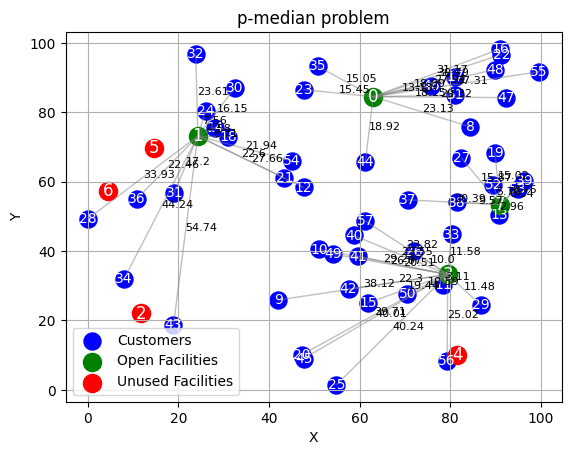

In [13]:
import matplotlib.pyplot as plt


# retrieve dictionaries from ampl with the solution
def retrieve_solution(model):
    # open facilities
    open = model.var["y"].to_dict()
    rounded_open = {key: int(round(value)) for key, value in open.items()}

    costs = model.getData(
        "{i in CUSTOMERS, j in FACILITIES} cost[i,j] * x[i,j]"
    ).to_dict()
    rounded_costs = {
        key: float(round(value, 2))
        for key, value in costs.items()
        if costs[key] >= 5e-6
    }
    return rounded_open, rounded_costs


# plot the solution given the nodes, which facilities are open, and the costs
def plot_graph(
    customers, facilities, open_facilities, connection_costs, title="p-median problem"
):
    # Extract customer and facility coordinates and plot nodes
    customer_x, customer_y = zip(*customers.values())
    plt.scatter(customer_x, customer_y, color="blue", label="Customers", s=150)
    for id, xy in customers.items():
        plt.text(xy[0], xy[1], id, color="white", fontsize=10, ha="center", va="center")

    open_facilities_coords = [
        (xy[0], xy[1]) for f, xy in facilities.items() if open_facilities[f] == 1
    ]
    open_facilities_x, open_facilities_y = zip(*open_facilities_coords)
    plt.scatter(
        open_facilities_x,
        open_facilities_y,
        color="green",
        label="Open Facilities",
        s=170,
    )

    close_facilities_coords = [
        (xy[0], xy[1]) for f, xy in facilities.items() if open_facilities[f] == 0
    ]
    close_facilities_x, close_facilities_y = zip(*close_facilities_coords)
    plt.scatter(
        close_facilities_x,
        close_facilities_y,
        color="red",
        label="Unused Facilities",
        s=170,
    )

    for id, xy in facilities.items():
        plt.text(xy[0], xy[1], id, color="white", fontsize=12, ha="center", va="center")

    # Plot edges and label them with costs
    for edge, cost in connection_costs.items():
        c, f = edge
        plt.plot(
            [customers[c][0], facilities[f][0]],
            [customers[c][1], facilities[f][1]],
            color="grey",
            linewidth=1,
            alpha=0.5,
        )

        plt.text(
            (customers[c][0] + facilities[f][0]) / 2,
            (customers[c][1] + facilities[f][1]) / 2,
            str(cost),
            fontsize=8,
            color="black",
        )

    # Set labels and title
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

    # Show legend
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()


open_facilities, costs = retrieve_solution(ampl)

# Plot the graph
plot_graph(customer_coordinates, facility_coordinates, open_facilities, costs)

HiGHS 1.10.0: HiGHS 1.10.0: optimal solution; objective 566.7635718
48 simplex iterations
1 branching nodes


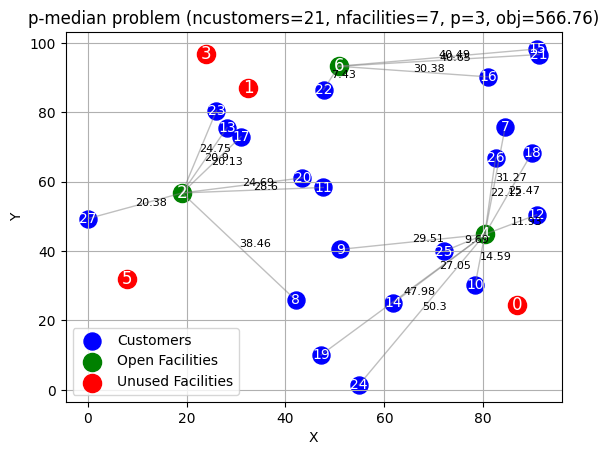

In [14]:
# main function to solve a random instance of the p-median problem using the previous functions
def solve_pmedian(num_customers, num_facilities, p):
    model = AMPL()
    # read model
    model.read("pmedian.mod")

    # get data
    (
        customers,
        facilities,
        p,
        costs,
        customer_coordinates,
        facility_coordinates,
    ) = prepare_data(num_customers, num_facilities, p)

    # load data into ampl
    load_data_2_ampl(model, customers, facilities, p, costs)

    # solve with highs
    model.solve(solver="highs")

    open_facilities, costs = retrieve_solution(model)

    obj_value = round(model.obj["total_cost"].value(), 2)
    title = (
        "p-median problem (ncustomers="
        + str(num_customers)
        + ", nfacilities="
        + str(num_facilities)
        + ", p="
        + str(p)
        + ", obj="
        + str(obj_value)
        + ")"
    )
    # Plot the graph
    plot_graph(
        customer_coordinates, facility_coordinates, open_facilities, costs, title
    )


solve_pmedian(num_customers=21, num_facilities=7, p=3)

### See also

- More examples in Facility Location:
https://colab.ampl.com/tags/facility-location.html

- amplpy documentation:
https://colab.ampl.com/tags/facility-location.html